# Import Statements

In [74]:
# First we will import the necessary Library 

import os
import pandas as pd
import numpy as np
import math
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import math

# For Evalution we will use these library

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

# For model building we will use these library

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# For PLotting we will use these library

import matplotlib.pyplot as plt
from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

from sklearn.preprocessing import MinMaxScaler

# Importing & Checking the Dataset

In [45]:
main_df = pd.read_csv("BTC-2017min.csv")

In [46]:
main_df.head()

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USD
0,1514764740,2017-12-31 23:59:00,BTC/USD,13913.28,13913.28,13867.18,13880.00,0.591748,8213.456549
1,1514764680,2017-12-31 23:58:00,BTC/USD,13913.26,13953.83,13884.69,13953.77,1.398784,19518.309658
2,1514764620,2017-12-31 23:57:00,BTC/USD,13908.73,13913.26,13874.99,13913.26,0.775012,10782.944294
3,1514764560,2017-12-31 23:56:00,BTC/USD,13827.00,13908.69,13827.00,13859.58,0.666459,9236.841134
4,1514764500,2017-12-31 23:55:00,BTC/USD,13825.05,13825.05,13825.05,13825.05,0.065501,905.560130


It is observed that the dataset is in descending order from latest to earliest data, so below we reverse the order.

In [47]:
#inverse data order
main_df = main_df.iloc[::-1]

In [48]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525599 entries, 525598 to 0
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   unix        525599 non-null  int64  
 1   date        525599 non-null  object 
 2   symbol      525599 non-null  object 
 3   open        525599 non-null  float64
 4   high        525599 non-null  float64
 5   low         525599 non-null  float64
 6   close       525599 non-null  float64
 7   Volume BTC  525599 non-null  float64
 8   Volume USD  525599 non-null  float64
dtypes: float64(6), int64(1), object(2)
memory usage: 36.1+ MB


In [49]:
print('Total number of days present in the dataset: ',main_df.shape[0])
print('Total number of fields present in the dataset: ',main_df.shape[1])

Total number of days present in the dataset:  525599
Total number of fields present in the dataset:  9


In [50]:
print('Null Values:',main_df.isnull().values.sum())

Null Values: 0


# Data Pre Processing

In [51]:
main_df = main_df.astype({'date': 'datetime64'})

In [52]:
main_df.drop(columns=['symbol','unix'], inplace=True)

In [53]:
main_df['weighed price'] = (main_df['high'] + main_df['low']) / 2

# EDA - Exploratory Data Analysis

In [54]:
# Printing the start date and End date of the dataset

sd=main_df.iloc[0][0]
ed=main_df.iloc[-1][0]


print('Starting Date',sd)
print('Ending Date',ed)

Starting Date 2017-01-01 00:01:00
Ending Date 2017-12-31 23:59:00


## Weighed Price vs Time

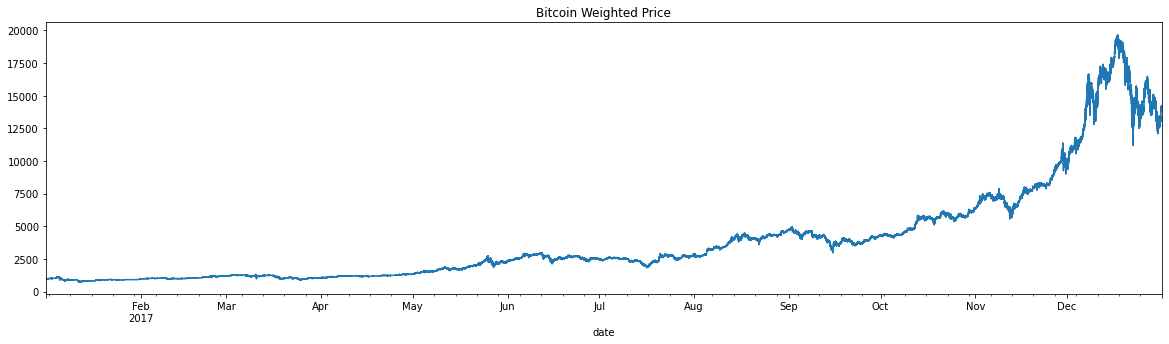

In [55]:
main_df.set_index("date").close.plot(figsize=(20,5), title="Bitcoin Weighted Price")

## Lag Plots

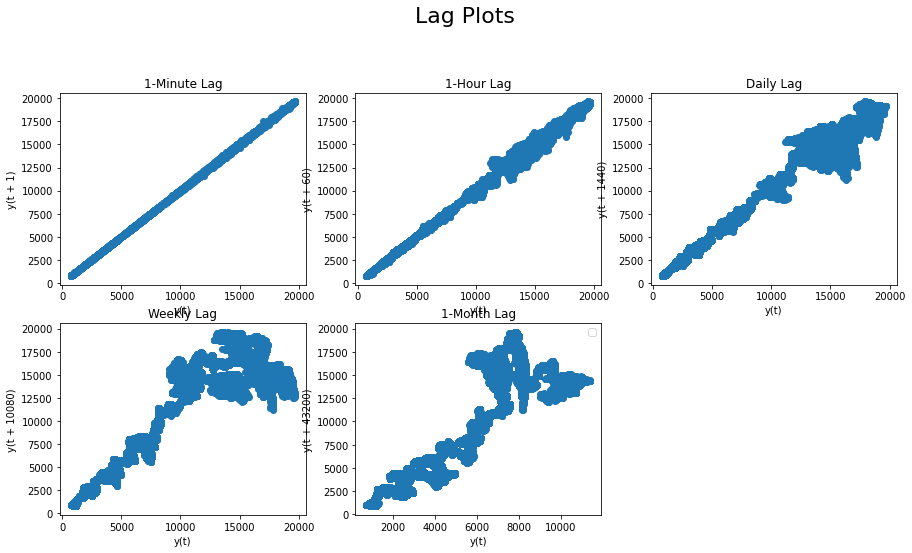

In [56]:
plt.figure(figsize=(15,12))
plt.suptitle('Lag Plots', fontsize=22)

plt.subplot(3,3,1)
pd.plotting.lag_plot(main_df['close'], lag=1) #minute lag
plt.title('1-Minute Lag')

plt.subplot(3,3,2)
pd.plotting.lag_plot(main_df['close'], lag=60) #hourley lag
plt.title('1-Hour Lag')

plt.subplot(3,3,3)
pd.plotting.lag_plot(main_df['close'], lag=1440) #Daily lag
plt.title('Daily Lag')

plt.subplot(3,3,4)
pd.plotting.lag_plot(main_df['close'], lag=10080) #weekly lag
plt.title('Weekly Lag')

plt.subplot(3,3,5)
pd.plotting.lag_plot(main_df['close'], lag=43200) #month lag
plt.title('1-Month Lag')

plt.legend()
plt.show()

There is a positive correlation for minute, hour and daily lag plots. This correlation decreases drastically with Weekly Lag and almost no correlation for month lag plots. Thus, we can re-sample our data atmost at the Daily level, thereby preserving the autocorrelation.

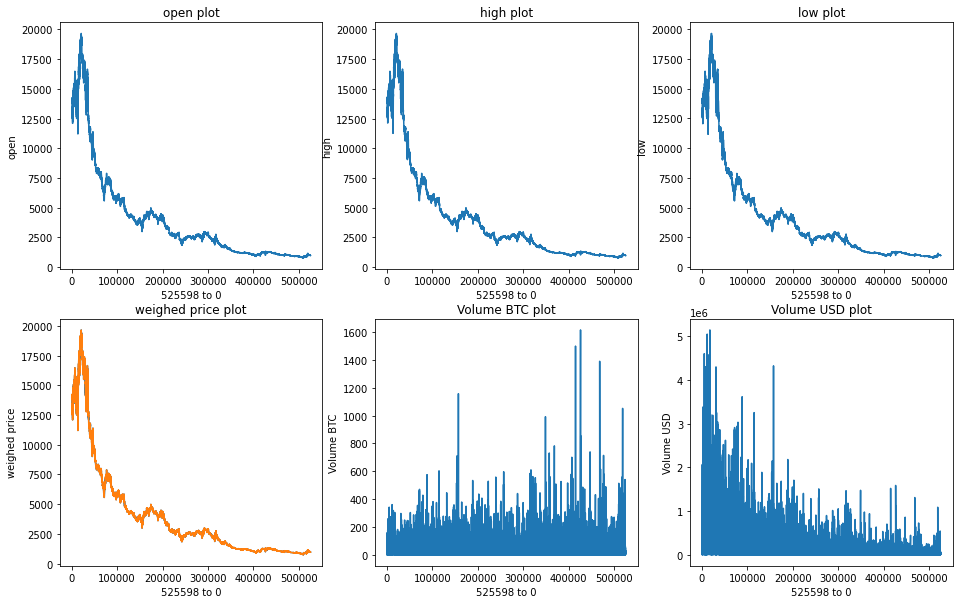

In [57]:
df = main_df.drop(columns=['date'], axis=1)
fig, axs = plt.subplots(len(df.columns)//3, 3, figsize = (16, 10))
for idx, i in enumerate(df.columns):
    row, col = 0 if idx<=2 else 1, idx%3
    axs[row, col].plot(df[i])
    axs[row, col].set_xlabel(f'{df.index[0]} to {df.index[-1]}')
    axs[row, col].set_ylabel(i)
    axs[row, col].set_title(f'{i} plot')

## Correlation Matrix (Heapmap)

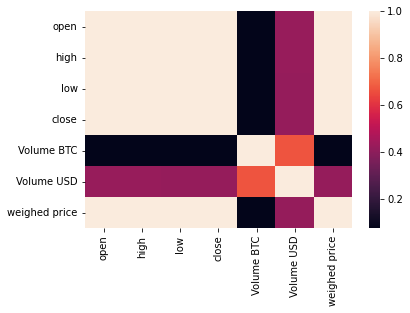

In [58]:
sns.heatmap(df.corr(), xticklabels=df.columns, yticklabels=df.columns)

# Data Preparation

In [70]:
required_features = ['open', 'high', 'low', 'Volume BTC', 'Volume USD', 'weighed price']
output_label = 'close'

In [71]:
x_train, x_test, y_train, y_test = train_test_split(
main_df[required_features],
main_df[output_label],
test_size = 0.3
)

# Linear Regression

## Training

In [61]:
model = LinearRegression()
model.fit(x_train, y_train)

LinearRegression()

In [62]:
model.score(x_test, y_test)

0.999996735590535

## Prediction

In [63]:
# We will now create a future dataset by shifting the original data by 30 days. We will use this to make predictions of future prices #

In [64]:
future_set = main_df.shift(periods=30).tail(30)

In [65]:
prediction = model.predict(future_set[required_features])

Text(0, 0.5, '$ Price')

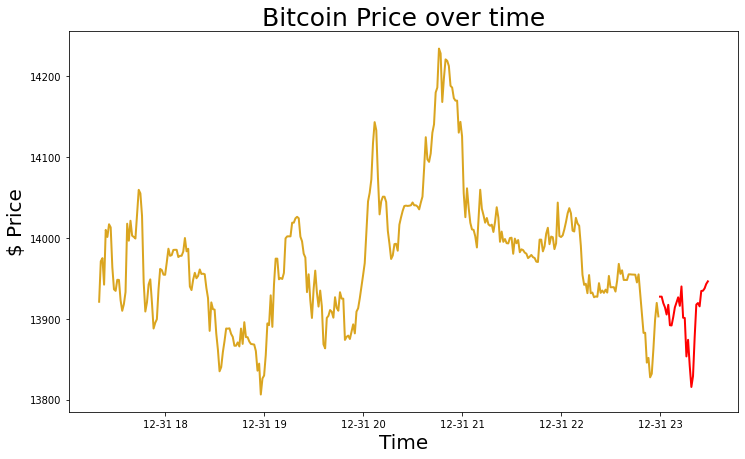

In [67]:
plt.figure(figsize = (12, 7))
plt.plot(main_df["date"][-400:-60], main_df["weighed price"][-400:-60], color='goldenrod', lw=2)
plt.plot(future_set["date"], prediction, color='red', lw=2)
plt.title("Bitcoin Price over time", size=25)
plt.xlabel("Time", size=20)
plt.ylabel("$ Price", size=20)

Graph in red shade is the prediction for next 30 days

# LSTM Model

## Data Preparation

In [69]:
# Lets First Take all the Close Price 
closedf = main_df[['date','close']]
print("Shape of close dataframe:", closedf.shape)

Shape of close dataframe: (525599, 2)


In [76]:
values = main_df['weighed price'].values.reshape(-1,1)
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [77]:
train_size = int(len(scaled) * 0.7)
test_size = len(scaled) - train_size
train, test = scaled[0:train_size,:], scaled[train_size:len(scaled),:]
print(len(train), len(test))

367919 157680


In [78]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

In [79]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

367918
157679


In [80]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

## Training

In [ ]:
model = Sequential()
model.add(LSTM(100, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
history = model.fit(trainX, trainY, epochs=300, batch_size=100, validation_data=(testX, testY), verbose=10, shuffle=False)

Epoch 1/300
Epoch 2/300
Epoch 3/300
Epoch 4/300
Epoch 5/300
Epoch 6/300
Epoch 7/300
Epoch 8/300
Epoch 9/300
Epoch 10/300
Epoch 11/300
Epoch 12/300
Epoch 13/300
Epoch 14/300
Epoch 15/300
Epoch 16/300
Epoch 17/300
Epoch 18/300
Epoch 19/300
Epoch 20/300
Epoch 21/300
Epoch 22/300
Epoch 23/300
Epoch 24/300
Epoch 25/300
Epoch 26/300
Epoch 27/300
Epoch 28/300
Epoch 29/300
Epoch 30/300
Epoch 31/300
Epoch 32/300
Epoch 33/300
Epoch 34/300
Epoch 35/300
Epoch 36/300
Epoch 37/300
Epoch 38/300
Epoch 39/300
Epoch 40/300
Epoch 41/300
Epoch 42/300
Epoch 43/300
Epoch 44/300
Epoch 45/300
Epoch 46/300
Epoch 47/300
Epoch 48/300
Epoch 49/300
Epoch 50/300
Epoch 51/300
Epoch 52/300
Epoch 53/300
Epoch 54/300
Epoch 55/300
Epoch 56/300
Epoch 57/300
Epoch 58/300
Epoch 59/300
Epoch 60/300
Epoch 61/300
Epoch 62/300
Epoch 63/300
Epoch 64/300
Epoch 65/300
Epoch 66/300
Epoch 67/300
Epoch 68/300
Epoch 69/300
Epoch 70/300
Epoch 71/300
Epoch 72/300
Epoch 73/300
Epoch 74/300
Epoch 75/300
Epoch 76/300
Epoch 77/300
Epoch 78

## Prediction

Make prediction using textX and plotting line graph against testY

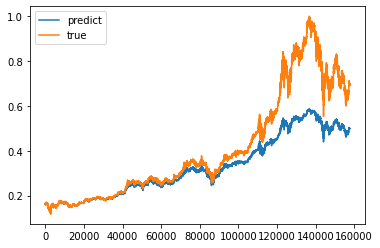

In [83]:
yhat = model.predict(testX)
plt.plot(yhat, label='predict')
plt.plot(testY, label='true')
plt.legend()
plt.show()

## Analysis

Plot line graph to show amount loss according the the epoch

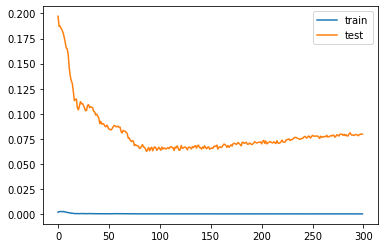

In [84]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [85]:
yhat_inverse = scaler.inverse_transform(yhat.reshape(-1, 1))
testY_inverse = scaler.inverse_transform(testY.reshape(-1, 1))

RMSE Error

In [86]:
rmse = math.sqrt(mean_squared_error(testY_inverse, yhat_inverse))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 2536.574
